# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [7]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict

21.894831181729206
average train MSE score: 21.193933513766574
average test MSE score: 25.507532313919494
T-Test metrics: T-Statistic=-2.3227663224054256, P-value=0.03144792965188975
The P-Value is outside of the standard 95% threshold, meaning we can reject the null hypothesisand conclude that the MSE is significantly smaller for the training data than for the test data


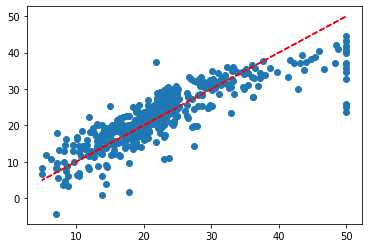

In [2]:
X, y = load_boston(return_X_y=True)

class OrdinaryLinearRegression:
    def fit(self, X, y):
        self.n, self.p = X.shape
        self.y = y
        x = np.c_[np.ones(self.n), X]
        X_inv = np.linalg.pinv(x)
        self.w = X_inv @ self.y
        
        return self
    
    def predict(self, X):
        return np.c_[np.ones(X.shape[0]), X ] @ self.w
    
    
    def score(self, X, y):
        y_hat = self.predict(X)
        mse = np.power((y_hat - y), 2).mean()
        return mse
    
OLS = OrdinaryLinearRegression()
OLS.fit(X, y)
y_hat = OLS.predict(X)
print(OLS.score(X, y))
plt.scatter(y, y_hat)
z = np.polyfit(y, y, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r--");
rs = ShuffleSplit(n_splits=20, test_size=0.25, train_size=0.75, random_state=42)
train_mses = []
test_mses = []
for train_idx, test_idx in rs.split(X, y=y):
    X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    OLS = OrdinaryLinearRegression().fit(X_train, y_train)
    train_mses.append(OLS.score(X_train, y_train))
    test_mses.append(OLS.score(X_test, y_test))
t_score = ttest_rel(train_mses, test_mses)
print(f'average train MSE score: {np.mean(train_mses)}')
print(f'average test MSE score: {np.mean(test_mses)}')
print(f'T-Test metrics: T-Statistic={t_score.statistic}, P-value={t_score.pvalue}')
print('The P-Value is outside of the standard 95% threshold, meaning we can reject the null hypothesis ' 
      'and conclude that the MSE is significantly smaller for the training data than for the test data')

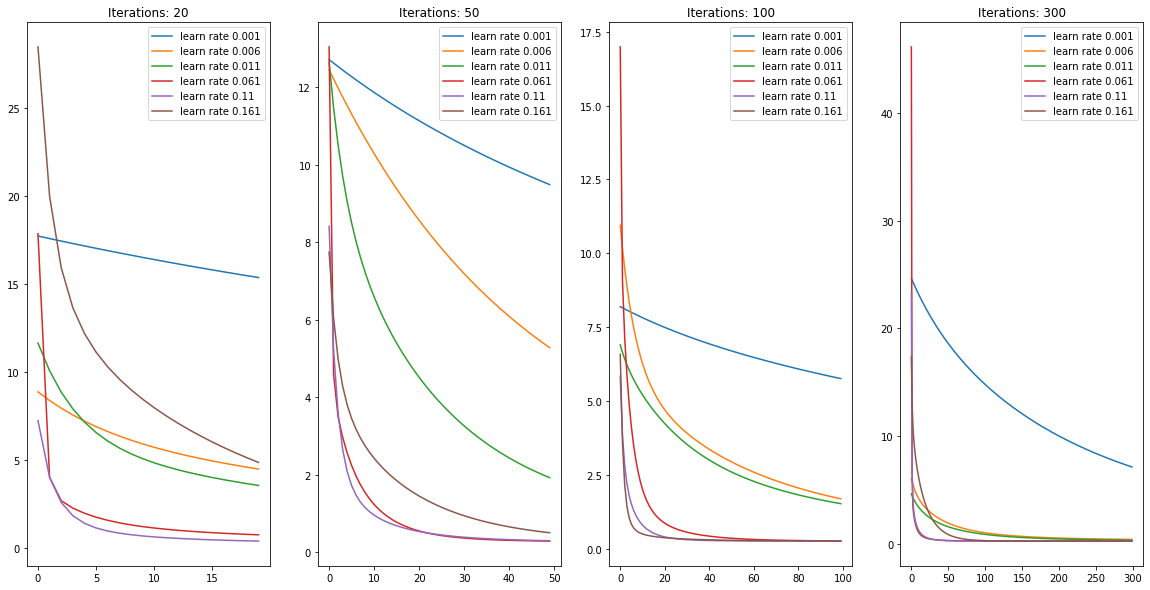

In [12]:
def scalingfeatures(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    def __init__(self, learn=None, n_iterations=None):
        if learn is None:
            learn = 0.1
        self.learn = learn
        if n_iterations is None:
            n_iterations = 100
        self.n_iterations = n_iterations
    
    def grad_descent(self, X, y, eps=None, halt=False):
        if eps is None:
            eps = 1e-3
        self.errors = []
        for i in range(self.n_iterations):
            y_hat = torch.mm(X, self.w)
            error = torch.pow((y_hat - y), 2).mean()
            self.errors.append(error.item())
            error.backward()
            
            with torch.no_grad():
                self.w.sub_(self.learn * self.w.grad)
                self.w.grad.zero_()
            
            self.w.require_grad = True
            
            if halt:
                if i > 1:
                    self.iterations = i+1
                    if self.errors[-2] - self.errors[-1] < eps:
                        print(f'Convergence achieved after {i} iterations')
                        break
        return None
    
    def fit(self, X, y):
        self.n, self.p = X.shape
        X = np.c_[np.ones(self.n), X]
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y)
        
        self.w = torch.randn((self.p+1, 1), requires_grad=True, dtype=torch.double)
        self.grad_descent(X, y, eps=1e-3, halt=False)
        self.w = self.w.detach().numpy()
        return None
    
# x_scaler = StandardScaler()
# y_scaler = StandardScaler()
X_scaled = scalingfeatures(X)
# y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
iterations = [20,50,100,300]
rates = [0.001, 0.006, 0.011, 0.061, 0.11,0.161]
errors = defaultdict(list)
for i in iterations:
    for r in rates:
        OLSGD = OrdinaryLinearRegressionGradientDescent(learn=r, n_iterations=i)
        OLSGD.fit(X_scaled, y_scaled)
        y_hat_scaled = OLSGD.predict(X_scaled)
#         print(f'Mean Squared Error with learning rate {r} and {i} iterations: {OLSGD.score(X_scaled, y_scaled)}')
        errors[i].append({r: OLSGD.errors})

fig, axs = plt.subplots(1, len(errors), figsize=(20,10))
for i, v in errors.items():
    for l in v:
        for r, e in l.items():
            ax = axs[iterations.index(i)]
            ax.plot(np.arange(i), e, label=f'learn rate {r}')
    ax.legend(loc="upper right")
    ax.title.set_text(f'Iterations: {i}')

**What is the effect of learning rate?**

A larger learning rate means that there will be a larger adjustment to the weight with each step of the gradient descent, meaning that a higher learning rate causes the function to converge in fewer iterations. Smaller learning rates need more iterations to converge.

The graph shows how the error function for the larger learning rates flatlines already after 20-50 iterations, while for the smaller learning rates they don't converge until 200+ iterations, meaning that they are slow to find the optimum weights.

However, if the learning rate is too high the function will overshoot the minimum and the error will grow.

**How would you find number of iteration automatically?** 

In order to stop optimizing when a local minimum is reached, it's common to set a small value as the convergence threshold and stop the gradient descent when the difference between the last and penultimate iterations is less than the convergence threshold. This is implemented above

**Note: Gradient Descent does not work well when features are not scaled evenly (why?!).**

It's not only G.D. but many algorithms that wont work well when the features aren't scaled evenly. This is because when we are dealing with data where the features are in different metrics, the algorithm isnt aware and just compares their numerical value, therefore giving disproportionate value to the features (Ex: If Xi - square meters of the house and Xj - number of bathrooms, with every additional bathroom in the house, the price of the house will increase dramatically, as opposed to the number of square meters). More generally, if we're traversing the n-dimensional feature space it will be a lot easier to find a particular spot iteratively if the distance covered in one dimension is proportional to the distance covered in the other dimensions.

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpreation? 



In [14]:
class OrdinaryLinearRegressionPadless:
    
    def fit(self,X,y):
        self.w = np.linalg.pinv(X) @ y
        return self
  
    def predict(self,X):
        return X@self.w

    def score(self,X,y):
        return np.power((self.predict(X) - y),2).mean()


def proveL2(X,y,y_hat,w,lam):
    
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    w = torch.from_numpy(w)
    w.requires_grad = True
    
    loss = torch.pow((torch.mv(X,w)-y),2).mean() + lam*(torch.sum(w**2))
    loss.backward()
       
    return w.grad.data.numpy()



OLRPl = OrdinaryLinearRegressionPadless()
model = OLRPl.fit(X_scaled,y)
w = model.w
y_hat = model.predict(X_scaled)

#Chose an arbitrary Lambda
lam = .5

#Analytic closed-form solution
w_ridge = np.linalg.pinv(X_scaled.T@X_scaled + np.identity(X_scaled.shape[1])*lam)@X_scaled.T@y

print(np.all(np.abs(w_ridge -  proveL2(X_scaled,y,y_hat,w,lam)) < 1e-1))

True


average train MSE score: 21.710414287310364
average test MSE score: 26.113806384338517
T-Test metrics: T-Statistic=-2.1012113481875336, P-value=0.049196217351642


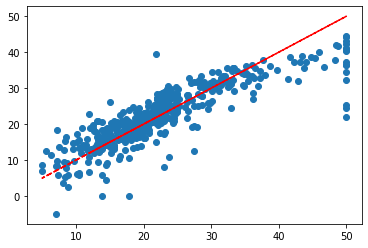

In [4]:
class RidgeLinearRegression(OrdinaryLinearRegression):
    def __init__(self, lmda=None):
        if lmda is None:
            lmda = 0.5
        self.lmda = lmda
    def fit(self, X, y, lmda=10):
        self.n, self.p = X.shape
        self.y = y
        I = np.eye(self.p+1)
        x = np.c_[np.ones(self.n), X ]
        self.w = (np.linalg.inv(x.T @ x + self.lmda * I) @ x.T @ y)
        return self
    
RLS = RidgeLinearRegression()
RLS.fit(X, y)
y_hat = RLS.predict(X)
plt.scatter(y, y_hat)
z = np.polyfit(y, y, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r--");
rs = ShuffleSplit(n_splits=20, test_size=0.25, train_size=0.75, random_state=42)
train_mses = []
test_mses = []
for train_idx, test_idx in rs.split(X, y=y):
    X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    RLS = RidgeLinearRegression().fit(X_train, y_train)
    train_mses.append(RLS.score(X_train, y_train))
    test_mses.append(RLS.score(X_test, y_test))
t_score = ttest(train_mses, test_mses)
print(f'average train MSE score: {np.mean(train_mses)}')
print(f'average test MSE score: {np.mean(test_mses)}')
print(f'T-Test metrics: T-Statistic={t_score.statistic}, P-value={t_score.pvalue}')

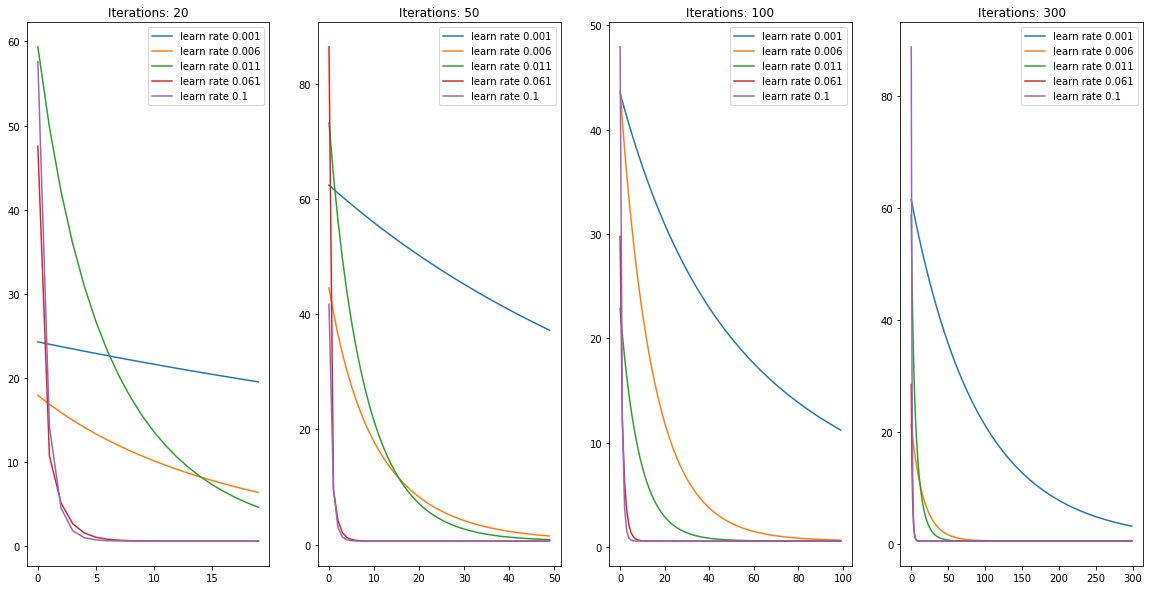

In [9]:
class RidgeLinearRegressionGradientDescent(OrdinaryLinearRegressionGradientDescent):
    def __init__(self, lmda=None, learn=None, n_iterations=None, penalty=None):
        if learn is None:
            learn = 0.1
        self.learn = learn
        if n_iterations is None:
            n_iterations = 100
        self.n_iterations = n_iterations
        if lmda is None:
            lmda = 0.5
        self.lmda = lmda
        if penalty is None:
            penalty = 1
        self.penalty = penalty
    
    def grad_descent(self, X, y, eps=None, halt=False,):
        if eps is None:
            eps = 1e-3
        self.errors = []
        for i in range(self.n_iterations):
            y_hat = torch.mm(X, self.w)
            error = torch.pow((y_hat - y), 2).mean() + self.lmda*torch.pow(self.w, self.penalty).sum()
            self.errors.append(error.item())
            error.backward()
            
            with torch.no_grad():
                self.w.sub_(self.learn * self.w.grad)
                self.w.grad.zero_()
            
            self.w.require_grad = True
            
            if halt:
                if i > 1:
                    self.iterations = i+1
                    if self.errors[-2] - self.errors[-1] < eps:
                        print(f'Convergence achieved after {i} iterations')
                        break
        return None
    
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
iterations = [20,50,100,300]
rates = [0.001, 0.006, 0.011, 0.061, 0.1]
errors = defaultdict(list)
for i in iterations:
    for r in rates:
        RLSGD = RidgeLinearRegressionGradientDescent(learn=r, n_iterations=i, lmda=2, penalty=2)
        RLSGD.fit(X_scaled, y_scaled)
        y_hat_scaled = RLSGD.predict(X_scaled)
#         print(f'Mean Squared Error with learning rate {r} and {i} iterations: {OLSGD.score(X_scaled, y_scaled)}')
        errors[i].append({r: RLSGD.errors})

fig, axs = plt.subplots(1, len(errors), figsize=(20,10))
for i, v in errors.items():
    for l in v:
        for r, e in l.items():
            ax = axs[iterations.index(i)]
            ax.plot(np.arange(i), e, label=f'learn rate {r}')
    ax.legend(loc="upper right")
    ax.title.set_text(f'Iterations: {i}')

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

In [ ]:
for degree in degrees:
    features = PF(degree=degree, include_bias=True)
    LR = LinearRegression()
    RR = RidgeCV()